In [1]:
import numpy as np
from datetime import datetime
import cv2
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
from dataset import Asbest_segmentation
from tqdm import tqdm
import matplotlib.pyplot as plt
import rawpy
import segmentation_models_pytorch as smp
from utils import parse_anno_file, create_mask_file, big_image_predict, get_time, true_results, get_pz_quantils, get_h, get_quartiles, plot_dist_pz
from apex import amp

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
def calculate_info(img_pathes, model, thresh=0.5):
    results = []
    size = 1024
    for obj in img_pathes:
        img = cv2.imread(obj, cv2.IMREAD_UNCHANGED)
        img, st, asb = big_image_predict(model, 
                                         img,
                                         crop_size=(size, size),
                                         inp_size=(size, size),
                                         device=device
                                        )
        results.append(len(np.where(asb > thresh)[0]) / img.shape[0] / img.shape[1])
    return results

In [3]:
path = 'asbestos/stones'

data = {
    '020221' : 
    { 
        1 : 
        {
            'mode' : 'manual',
            'state' : 'accepted',
            'content' : 0.030,
            'n' : 5, 
            'sort_images' : {},
            'res' : {},
            'images' : 
            { 0 : 
             [
                'asbestos/stones/020221/ManualDetailedImage_12_04_45f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_05_01_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_06_30f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_07_14_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_08_07f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_08_29_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_09_38f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_09_52_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_11_17f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_11_32_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_13_48f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_14_01_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_15_13f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_15_45_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_17_26f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_17_46_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_19_00f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_19_17_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_23_52f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_24_11_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_25_15f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_25_24_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_27_03f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_27_48_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_31_20f_300.bmp', 
                'asbestos/stones/020221/ManualDetailedImage_12_32_00_300.bmp'
             ]
            },
        },
        2 : 
        {
            'mode' : 'manual',
            'state' : 'accepted',
            'content' : 0.015,
            'n' : 6, 
            'sort_images' : {},
            'res' : {},
            'images' : 
            { 0 :
            [
                 'asbestos/stones/020221/ManualDetailedImage_12_47_38f_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_49_13_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_51_54f_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_52_28_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_55_14f_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_55_48_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_58_06f_150.bmp', 
                 'asbestos/stones/020221/ManualDetailedImage_12_58_51_150.bmp'
            ]
            }
        }
    },
    '161220': 
     { 
         2 : 
         {
             'mode' : 'manual',
             'state' : 'declined',
             'content' : 0.02,
             'n' : 2,
             'sort_images' : {},
             'res' : {},
             'images' :
             { 0 :
             [
                 'asbestos/stones/161220/ManualDetailedImage_10_01_52.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_03_00.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_03_35.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_04_15.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_05_20.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_05_58.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_06_46.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_07_31.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_10_10.bmp',
                 'asbestos/stones/161220/ManualGeneralImage_10_01_26.bmp'
             ]
             }
         },
         3 : 
         {
             'mode' : 'manual',
             'state' : 'declined',
             'content' : 0.02,
             'n' : 3,
             'sort_images' : {},
             'res' : {},
             'images' :
             { 0 :
             [
                 'asbestos/stones/161220/ManualDetailedImage_10_26_43.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_27_18.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_27_30.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_27_58.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_10_29_22.bmp',
             ]
             },
         },
         4: 
         {
             'mode' : 'manual',
             'state' : 'accepted',
             'content' : 0.04,
             'n' : 4,
             'sort_images' : {},
             'res' : {},
             'images' : 
             { 1 :
             [
                 'asbestos/stones/161220/ManualDetailedImage_11_03_34.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_04_07.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_05_06.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_05_43.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_06_02.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_06_30.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_07_12.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_07_55.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_08_37.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_09_00.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_09_20.bmp', 
                 'asbestos/stones/161220/ManualDetailedImage_11_09_58.bmp'
             ],
             }
         },
         1: 
         {
             'mode' : 'manual',
             'state' : 'accepted',
             'content' : 0.02,
             'n' : 1,
             'sort_images' : {},
             'res' : {},
             'images' : {
                 0 :
             [
                  'asbestos/stones/161220/ManualGeneralImage_09_27_13.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_30_19.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_31_25.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_32_23.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_35_25.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_35_52.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_36_12.bmp', 
                  'asbestos/stones/161220/ManualGeneralImage_09_36_44.bmp'
             ]
             }
         }
     },
    '230321' : 
    { 1 : 
     { 
         'mode' : 'auto',
         'content' : 0.025,
         'n' : 7,
         'sort_images' : {},
         'res' : {},
         'images' : {
#              1 : [
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-18_1_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-29_2_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-37_3_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-46_4_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-15-51_5_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-16-24_8_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-16-37_9_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-16-48_10_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-17-04_11_1_detailed.bmp',
# #              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-17-49_14_1_detailed.bmp',
# #              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-18-01_15_1_detailed.bmp',
# #              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-19-36_22_1_detailed.bmp',
# #              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-19-51_23_1_detailed.bmp',
# #              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-20-42_28_1_detailed.bmp',
# #              'asbestos/stones/230321/1/AutoScan_11_14_28/23-03-2021-11-21-05_30_1_detailed.bmp',
#          ],
#              2 : [
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-39-39_1_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-39-55_2_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-01_3_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-09_4_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-19_5_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-29_6_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-35_7_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-47_8_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-40-55_9_1_detailed.bmp',
# #                  'asbestos/stones/230321/1/AutoScan_11_38_51/23-03-2021-11-41-11_10_1_detailed.bmp',
#              ]
                    },
     },
     2 : 
     {
         'mode' : 'auto',
         'state' : 'declined',
         'content' : 0.035,
         'n' : 8,
         'sort_images' : {},
         'res' : {},
         'images' : {},
     },
     3 : 
     {
         'mode' : 'auto',
         'state' : 'accepted',
         'content' : 0.025,
         'n' : 9,
         'sort_images' : {},
         'res' : {},
         'images' : {},
     }
    },
    '200421' : 
    {
        1 : 
        {
            'mode' : 'auto',
            'state' : 'declined',
            'content' : 0.04,
             'n' : 10,
             'sort_images' : {},
             'res' : {},
             'images' : {},
        },
        2 : 
        {
            'mode' : 'auto',
            'state' : 'accepted',
            'content' : 0.025,
             'n' : 11,
             'sort_images' : {},
             'res' : {},
             'images' : {},
        },
        3 : 
        {
            'mode' : 'auto',
            'state' : 'accepted',
            'content' : 0.015,
             'n' : 12,
             'sort_images' : {},
             'res' : {},
             'images' : {},
        },
    },
    '270421' :
    {
        1 : 
        {
            'mode' : 'auto',
            'state' : 'accepted',
            'content' : 0.015,
            'n' : 13,
            'sort_images' : {},
            'res' : {},
            'images' : {},
        },
        2 : 
        {
            'mode' : 'auto',
            'state' : 'accepted',
            'content' : 0.025,
            'n' : 14,
            'sort_images' : {},
            'res' : {},
            'images' : {},
        },
        3 : 
        {
            'mode' : 'auto',
            'state' : 'accepted',
            'content' : 0.04,
            'n' : 15,
            'sort_images' : {},
            'res' : {},
            'images' : {},
        },
        4 : 
        {
            'mode' : 'auto',
            'state' : 'accepted',
            'content' : 0.025,
            'n' : 16,
            'sort_images' : {},
            'res' : {},
            'images' : {},
        }
    }
}

In [4]:
for pit in os.listdir(os.path.join(path, '230321')):
    for i, case in enumerate(os.listdir(os.path.join(path, '230321', pit))):
        data['230321'][int(pit)]['images'][i] =  sorted([os.path.join(path, '230321', pit, case, file) for file in os.listdir(os.path.join(path, '230321', pit, case)) if file.endswith('detailed.bmp')])

for date in ['200421', '270421']:        
    for pit in os.listdir(os.path.join(path, date)):
        for i, case in enumerate(os.listdir(os.path.join(path, date, pit))):
            data[date][int(pit)]['images'][i] =  sorted([os.path.join(path, date, pit, case, 'Detailed', file) for file in os.listdir(os.path.join(path, date, pit, case, 'Detailed')) if file.endswith('detailed.bmp')])

In [5]:
device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

model_asbest = smp.Unet(encoder_name='efficientnet-b3', in_channels=1, classes=2, activation='sigmoid').to(device)
model_asbest.load_state_dict(torch.load('asbest_segmentation_b3_v1.3.pth'))
model_asbest.eval();

In [6]:
for date in tqdm(data.keys(), total=len(data.keys())):
    for pit in data[date].keys():
#         if data[date][pit]['state'] is 'declined':
#             continue
        for ind in data[date][pit]['images'].keys():
            res = calculate_info(np.array(data[date][pit]['images'][ind]), model_asbest, thresh=0.5)
            indexes = np.argsort(res)[::-1]
            data[date][pit]['sort_images'][ind] = list(np.array(data[date][pit]['images'][ind])[indexes])
            data[date][pit]['res'][ind] = list(np.array(res)[indexes])


100%|██████████| 5/5 [16:46<00:00, 201.30s/it]


In [7]:
if thresholds is not None:
    results['pred_content'] = dict()
    results.keys

NameError: name 'thresholds' is not defined

In [8]:
# num_images = 100
all_stones = False
thresholds = np.linspace(0, 0.02, 21)
# dist = lambda x, y : abs(1.2462118 * x - y + 0.00266083) / (1.2462118 ** 2 + 1) ** (1/2)
results = {'content' : [], 'date' : [], 'num_frames' : [], 'pit_of_date' : [], 'pit' : [], 'scene': [], 'optimal_stones' : [], 'pred_content' : {}, 'mode' : [], 'results' : []}
if thresholds is not None:
    results['pred_content'] = dict()
    for t in thresholds:
        results['pred_content'][t] = []
for date in tqdm(data.keys(), total=len(data.keys())):
    for pit in data[date].keys():
#         if data[date][pit]['state'] is 'declined':
#             continue
        content = data[date][pit]['content']    
        y = 100 * content
        for ind in data[date][pit]['res'].keys():
            results['pit'].append(data[date][pit]['n'])
            results['content'].append(y)
            results['date'].append(date)
            results['scene'].append(ind)
            results['pit_of_date'].append(pit)
            results['num_frames'].append(len(data[date][pit]['res'][ind]))
            results['mode'].append(data[date][pit]['mode'])
            results['results'].append(data[date][pit]['res'][ind])
            losses = []
            pred_contents = []
            if all_stones:
                h = get_h(np.array(data[date][pit]['res'][ind]))
                q5, q50, q95 = get_pz_quantils(np.array(data[date][pit]['res'][ind]), h)
                x = 100 * q50
                results['pred_content']['all'].append(x)
                results['optimal_stones'].append(len(data[date][pit]['res'][ind]))
            else:
                if thresholds is not None:
                    for t in thresholds:
                        points = np.array(data[date][pit]['res'][ind])[data[date][pit]['res'][ind] >= t]
                        if len(points) == 0:
                            x = 0                            
                        elif len(points) == 1:
                            x = 100 * points[0]
#                             pred_contents.append(x)
#                             continue
                        else:
                            h = get_h(points)
                            q5, q50, q95 = get_pz_quantils(points, h)
                            x = 100 * q50
#                             pred_contents.append(x)
                        
                        results['pred_content'][t].append(x)
                else:
                    for num_stone in range(1, len(data[date][pit]['res'][ind]) + 1):
                        if num_stone == 1:
                            x = 100 * data[date][pit]['res'][ind][0]
                            losses.append(dist(x,y))
                            pred_contents.append(x)
                            continue
                        h = get_h(np.array(data[date][pit]['res'][ind])[:num_stone])
                        q5, q50, q95 = get_pz_quantils(np.array(data[date][pit]['res'][ind])[:num_stone], h)
                        x = 100 * q50
                        losses.append(dist(x,y))
                        pred_contents.append(x)
                    index = np.argmin(losses)
                    results['pred_content'].append(pred_contents[index])
                    results['optimal_stones'].append(index+1)

 40%|████      | 2/5 [00:03<00:04,  1.63s/it]/home/vasily/proj/asbest/utils.py:224: RuntimeWarning: divide by zero encountered in log
  l.append(np.log(np.sum([dist_norm((a[i] - a[j]) / h) for j in range(len(a)) if i != j]) / (len(a) - 1) / h))
100%|██████████| 5/5 [01:14<00:00, 14.91s/it]


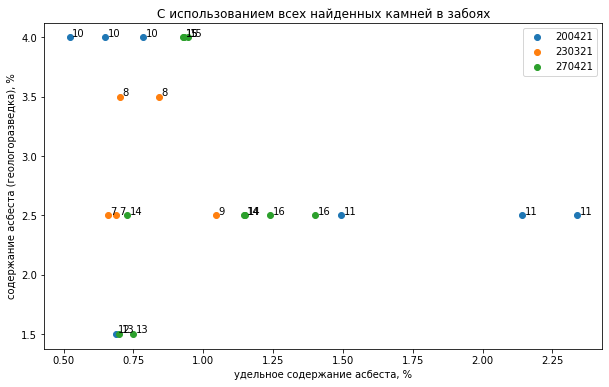

In [31]:
plt.figure(figsize=(10,6))
t = 0.00
indexes_mode = np.array(results['mode']) == 'auto'
for date in np.unique(np.array(results['date'])[indexes_mode]):
    indexes = np.array(results['date']) == date
    plt.scatter(np.array(results['pred_content'][t])[indexes], np.array(results['content'])[indexes], label=date)
plt.legend()

for i, (x, y) in enumerate(zip(np.array(results['pred_content'][t])[indexes_mode], np.array(results['content'])[indexes_mode])):
    plt.text(x+0.01, y+0.01, np.array(results['pit'])[indexes_mode][i])

# t = [0.5, 3.5]
# p = [1.2462118, 0.00266083]
# y = np.polyval(p, t)
# plt.plot(t, y)

# plt.title('С учетом выбора количества оптимальных камней')
plt.title('С использованием всех найденных камней в забоях')
plt.xlabel('удельное содержание асбеста, %')
plt.ylabel('содержание асбеста (геологоразведка), %')
plt.savefig('graphics/results_auto_stones.png', dpi=300, bbox_inches='tight', pad_inches=0)

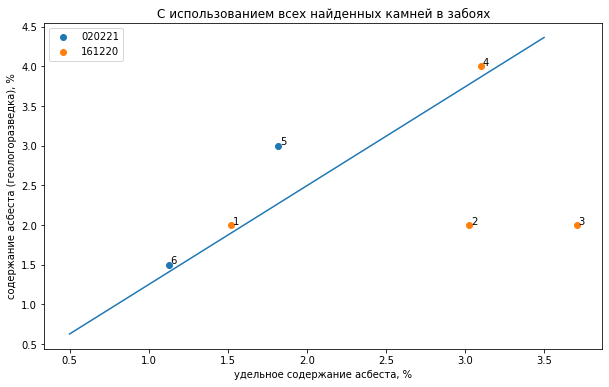

In [33]:
plt.figure(figsize=(10,6))
t = 0.00
indexes_mode = np.array(results['mode']) == 'manual'
for date in np.unique(np.array(results['date'])[indexes_mode]):
    indexes = np.array(results['date']) == date
    plt.scatter(np.array(results['pred_content'][t])[indexes], np.array(results['content'])[indexes], label=date)
plt.legend()

for i, (x, y) in enumerate(zip(np.array(results['pred_content'][t])[indexes_mode], np.array(results['content'])[indexes_mode])):
    plt.text(x+0.01, y+0.01, np.array(results['pit'])[indexes_mode][i])

t = [0.5, 3.5]
p = [1.2462118, 0.00266083]
y = np.polyval(p, t)
plt.plot(t, y)

# plt.title('С учетом выбора количества оптимальных камней')
plt.title('С использованием всех найденных камней в забоях')
plt.xlabel('удельное содержание асбеста, %')
plt.ylabel('содержание асбеста (геологоразведка), %')
plt.savefig('graphics/results_manual_stones.png', dpi=300, bbox_inches='tight', pad_inches=0)

## Гистограммы распределений

In [54]:
# t = 0.00
# for index in np.where(np.array(results['mode']) == 'auto')[0]:
#     plt.figure(figsize=(10,6))
#     res = 100 * np.array(results['results'][index])[np.array(results['results'][index]) > t]
#     h = get_h(res)
#     _, q50, _ = plot_dist_pz(res, h)
#     plt.title('Забой № ' + str(results['pit'][index]) + ' съемка ' + str(results['scene'][index]+1) + ' (' + results['date'][index] + ') вычисление по всем найденным камням')
#     plt.savefig('graphics/hist_pit_' + str(results['pit'][index]) + '_' + str(results['scene'][index]+1) + '.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [50]:
med_value = [np.median(100*np.array(res)) for res in results['results']]
var_value = [np.var(100*np.array(res)) for res in results['results']]


In [52]:
results.keys()

dict_keys(['content', 'date', 'num_frames', 'pit_of_date', 'pit', 'scene', 'optimal_stones', 'pred_content', 'mode', 'results'])

In [53]:
import pandas as pd
df = pd.DataFrame({
    'pit' : results['pit'],
    'content' : results['content'],
    'median' : [it for it in med_value],
    'variance' : [it for it in var_value],
})
df

,pit,content,median,variance
0,5,3.0,1.472228,1.011076
1,6,1.5,1.170735,0.260926
2,2,2.0,2.799112,1.153927
3,3,2.0,3.707829,1.500909
4,4,4.0,3.187712,0.825747
5,1,2.0,1.507135,0.051845
6,7,2.5,0.689057,0.161585
7,7,2.5,0.652822,0.088155
8,8,3.5,0.700360,0.085831
9,8,3.5,0.844527,0.167197


## Выбор порога

In [67]:
results['pred_content'].keys()

dict_keys([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01, 0.011, 0.012, 0.013000000000000001, 0.014, 0.015, 0.016, 0.017, 0.018000000000000002, 0.019, 0.02])

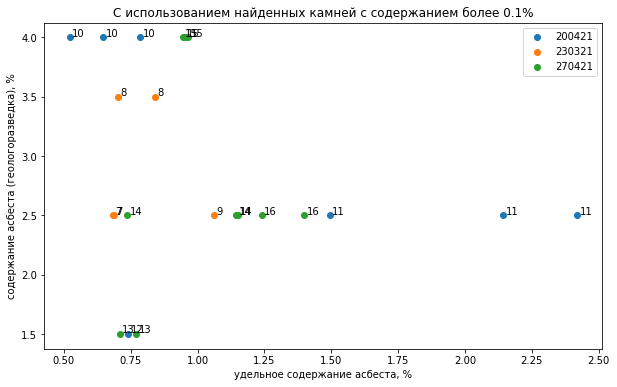

In [72]:
plt.figure(figsize=(10,6))
t = 0.001
indexes_mode = np.array(results['mode']) == 'auto'
for date in np.unique(np.array(results['date'])[indexes_mode]):
    indexes = np.array(results['date']) == date
    plt.scatter(np.array(results['pred_content'][t])[indexes], np.array(results['content'])[indexes], label=date)
plt.legend()

for i, (x, y) in enumerate(zip(np.array(results['pred_content'][t])[indexes_mode], np.array(results['content'])[indexes_mode])):
    plt.text(x+0.01, y+0.01, np.array(results['pit'])[indexes_mode][i])

# t = [0.5, 3.5]
# p = [1.2462118, 0.00266083]
# y = np.polyval(p, t)
# plt.plot(t, y)

# plt.title('С учетом выбора количества оптимальных камней')
plt.title('С использованием найденных камней с содержанием более ' + str(100*t) + '%')
plt.xlabel('удельное содержание асбеста, %')
plt.ylabel('содержание асбеста (геологоразведка), %')
plt.savefig('graphics/results_auto_stones_'+ str(100*t) +'.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [35]:
dist = lambda x, y : abs(1.2462118 * x - y + 0.00266083) / (1.2462118 ** 2 + 1) ** (1/2)

In [73]:
loss = []
date = '200421'
pit = 2
num_scene = 2
y = 100*data[date][pit]['content']
for i in tqdm(range(1, len(data[date][pit]['res'][num_scene])), total=len(data[date][pit]['res'][num_scene])-1):
    if i == 1:
        q50 = data[date][num_pit]['res'][num_scene][0]
    else:
        h = get_h(np.array(data[date][pit]['res'][num_scene][:i]))
        q5, q50, q95 = get_pz_quantils(data[date][pit]['res'][num_scene][:i], h)
    x = 100*q50
    loss.append(dist(x,y))

100%|██████████| 43/43 [00:06<00:00,  7.12it/s]


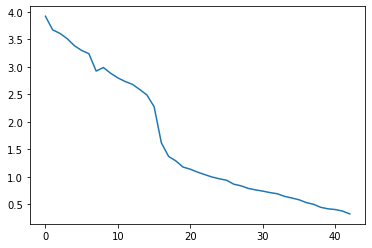

In [74]:
plt.plot(loss)